To mount Google Drive in Google Colab, please execute the code below.

In [1]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


Define the directory.

In [2]:
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.chdir('/content')

# create a working folder
root_dir = os.path.join(os.getcwd(), 'drive', 'MyDrive', 'woa7015-med-vqa')
data_dir = os.path.join(root_dir, 'data', 'Slake1.0')
img_dir = os.path.join(data_dir, 'imgs')
working_dir = os.path.join(root_dir, 'baseline-vgglstm')

if not os.path.exists(working_dir):
    os.makedirs(working_dir)

if os.getcwd() != working_dir:
    os.chdir(working_dir)

assert os.getcwd() == working_dir
print(f"Root directory: {root_dir}")
print(f"Data directory: {data_dir}")
print(f"Image directory: {img_dir}")
print(f"Working directory: {working_dir}")
print(f"Current directory: {os.getcwd()}")

Root directory: /content/drive/MyDrive/woa7015-med-vqa
Data directory: /content/drive/MyDrive/woa7015-med-vqa/data/Slake1.0
Image directory: /content/drive/MyDrive/woa7015-med-vqa/data/Slake1.0/imgs
Working directory: /content/drive/MyDrive/woa7015-med-vqa/baseline-vgglstm
Current directory: /content/drive/MyDrive/woa7015-med-vqa/baseline-vgglstm


Load the `SLAKE` dataset

In [3]:
import pandas as pd

train_df = pd.read_json(os.path.join(data_dir, 'train.json'))
validate_df = pd.read_json(os.path.join(data_dir, 'validate.json'))
test_df = pd.read_json(os.path.join(data_dir, 'test.json'))

print("train:", train_df.shape)
print("validate:", validate_df.shape)
print("test:", test_df.shape)

train: (9835, 12)
validate: (2099, 12)
test: (2094, 12)


Filter the records that have Chinese questions.

In [4]:
train_df = train_df[train_df['q_lang'] == 'en'].reset_index(drop=True)
validate_df = validate_df[validate_df['q_lang'] == 'en'].reset_index(drop=True)
test_df = test_df[test_df['q_lang'] == 'en'].reset_index(drop=True)

print("train:", train_df.shape)
print("validate:", validate_df.shape)
print("test:", test_df.shape)

train: (4919, 12)
validate: (1053, 12)
test: (1061, 12)


A glance of the dataset

In [5]:
sample_df = train_df.sample(5)
sample_df

,img_id,img_name,question,answer,q_lang,location,modality,answer_type,base_type,content_type,triple,qid
2232,334,xmlab334/source.jpg,Where is/are the abnormality located in this p...,Both Lung,en,Lung,X-Ray,OPEN,vqa,Position,"[vhead, _, _]",2232
4844,89,xmlab89/source.jpg,Where is/are the abnormality located?,"Left Lung, Upper Right",en,Lung,CT,OPEN,vqa,Position,"[vhead, _, _]",4844
4565,623,xmlab623/source.jpg,Is there small bowel in this image?,Yes,en,Pelvic Cavity,CT,CLOSED,vqa,Organ,"[vhead, _, _]",4565
2666,376,xmlab376/source.jpg,Which organs/organ is part of the circulatory ...,Heart,en,Lung,X-Ray,OPEN,kvqa,KG,"[vhead, part of, circulatory system]",2666
4915,99,xmlab99/source.jpg,Does the picture contain liver?,Yes,en,Lung,CT,CLOSED,vqa,Organ,"[vhead, _, _]",4915


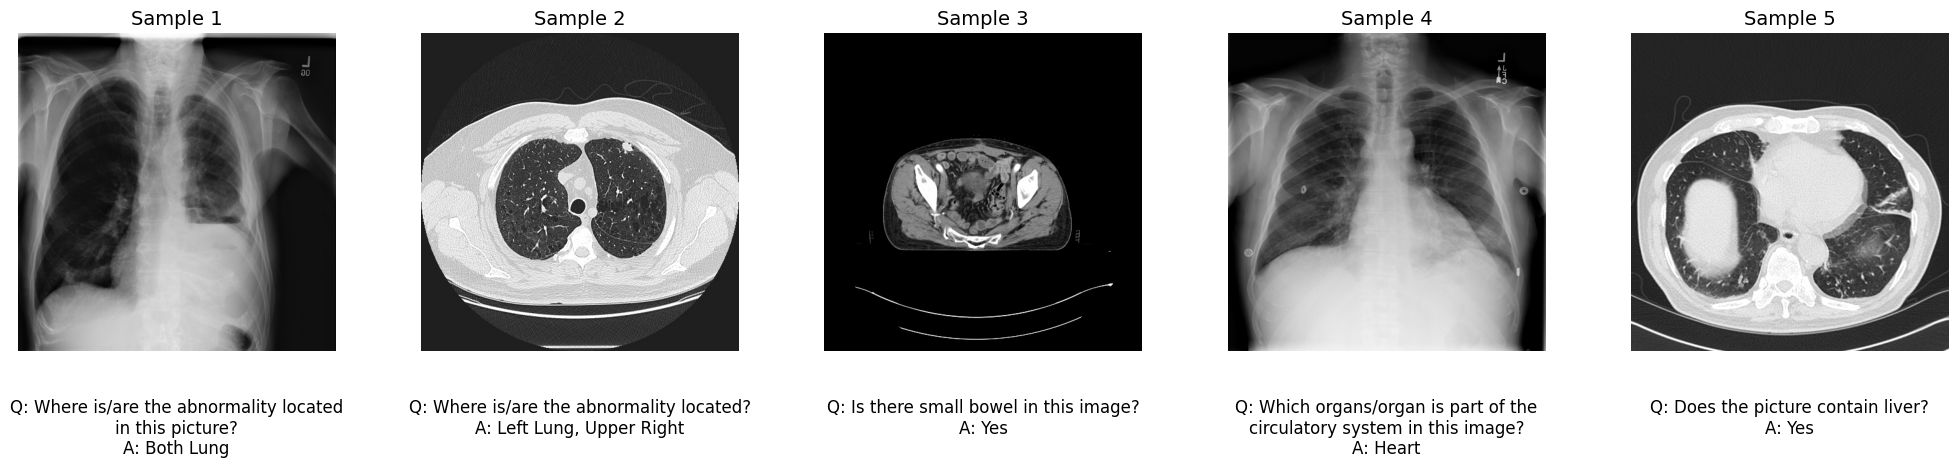

In [6]:
import matplotlib.pyplot as plt
import cv2, os, textwrap
def show_samples(df, img_dir):
    """
    Display images in one row with Question & Answer shown BELOW each image.
    df must contain: img_name, question, answer
    """
    n = len(df)
    plt.figure(figsize=(4*n, 7))  # height increased for Q&A text

    for i, row in enumerate(df.itertuples(), 1):
        img_path = os.path.join(img_dir, row.img_name)

        # Read image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Create subplot
        ax = plt.subplot(1, n, i)
        ax.imshow(img)
        ax.axis("off")

        plt.title(f"Sample {i}", fontsize=14, loc='center')

        # Wrap text nicely (adjust width depending on image size)
        q_text = textwrap.fill(f"Q: {row.question}", width=40)
        a_text = textwrap.fill(f"A: {row.answer}", width=40)

        # Add text BELOW the image using .text()
        ax.text(
            0.5, -0.15, f"{q_text}\n{a_text}",
            ha="center", va="top",
            fontsize=12,
            transform=ax.transAxes
        )

    plt.tight_layout()
    plt.show()


show_samples(sample_df, img_dir=img_dir)

Build Vocabulary for Answer

In [7]:
def build_answer_vocab(df):
    answers = sorted(df["answer"].dropna().unique())

    ans_to_idx = {ans: idx for idx, ans in enumerate(answers)}
    idx_to_ans = {idx: ans for ans, idx in ans_to_idx.items()}

    return ans_to_idx, idx_to_ans

Build SLAKEDataset

In [8]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd
import torch, json, os

class SLAKEDataset(Dataset):
    def __init__(self, df, img_dir, tokenizer, ans_to_idx, max_seq_len=50, transform=None):
        self.data = df
        self.img_dir = img_dir
        self.tokenizer = tokenizer
        self.ans_to_idx = ans_to_idx
        self.max_seq_len = max_seq_len

        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)), transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]

        # Load image
        img_path = os.path.join(self.img_dir, item['img_name'])
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)

        # Tokenize question
        question = item['question']
        tokens = self.tokenizer.encode(
            question,
            max_length=self.max_seq_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        ).squeeze(0)

        # Get answer index
        answer = item['answer']
        answer_idx = self.ans_to_idx.get(answer, 0)  # 0 for unknown

        return {
            "qid": torch.tensor(item["qid"], dtype=torch.long),
            'image': image,
            'question': tokens,
            'answer': torch.tensor(answer_idx, dtype=torch.long)
        }

Build ImageEncoder - VGG19

In [9]:
import torch
import torch.nn as nn
from torchvision import models

class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1) # load vgg model
        self.vgg.classifier = nn.Identity()      # remove the classifier
        self.fc = nn.Linear(25088, 512)          # add a linear layer

        # freeze all parameters
        for param in self.parameters():
                param.requires_grad = False

    def forward(self, x):
        features = self.vgg.features(x)                             # (B, 512, 7, 7)
        B, C, H, W = features.shape
        features = features.view(B, C, H * W)                       # (B, 512, 49)
        features = features.permute(0, 2, 1)                        # (B, 49, 512)
        features = features.contiguous().view(features.size(0), -1) # (B, 25088)
        features = self.fc(features)                                # (B, 512)
        return features

Check the output shape.

In [10]:
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
ans_to_idx, idx_to_ans = build_answer_vocab(train_df)

train_dataset = SLAKEDataset(df=train_df, img_dir=img_dir, tokenizer=tokenizer, ans_to_idx=ans_to_idx)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
img_extractor = ImageEncoder().to(device)

for batch in train_loader:
    images = batch['image'].to(device)

    with torch.no_grad():
        features = img_extractor(images)

    print(features.shape)
    break

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:04<00:00, 140MB/s]


torch.Size([32, 512])


Build QuestionEncoder - LSTM

In [11]:
import torch
import torch.nn as nn
from torchvision import models

class QuestionEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=300):
        super().__init__()
        self.word_embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_size=512, batch_first=True)
        self.fc = nn.Linear(25600, 512)

    def forward(self, x):
        embedding = self.word_embedding(x)              # (B, 50, 300)
        tokens, (h_n, c_n) = self.lstm(embedding)       # (B, 50, 512)
        tokens = tokens.contiguous().view(tokens.size(0), -1) # (B, 25600)
        tokens = self.fc(tokens)                        # (B, 512)
        return tokens                                   # (B, 512)

Check the output shape.

In [12]:
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
ans_to_idx, idx_to_ans = build_answer_vocab(train_df)

train_dataset = SLAKEDataset(df=train_df, img_dir=img_dir, tokenizer=tokenizer, ans_to_idx=ans_to_idx)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
question_encoder = QuestionEncoder(vocab_size=tokenizer.vocab_size).to(device)

for batch in train_loader:
    question = batch['question'].to(device)

    with torch.no_grad():
        tokens = question_encoder(question)

    print(tokens.shape)
    break

torch.Size([32, 512])


Build VQAModel - VGG+LSTM

In [13]:
import torch
import torch.nn as nn
from torchvision import models

class VQAModel(nn.Module):
    def __init__(self, vocab_size, ans_vocab_size):
        super().__init__()
        self.img_encoder = ImageEncoder()
        self.question_encoder = QuestionEncoder(vocab_size)
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, ans_vocab_size)
        )

    def forward(self, image, question):
        features = self.img_encoder(image)              # (B, 512)
        tokens = self.question_encoder(question)        # (B, 512)
        fused = torch.cat([features, tokens], dim=1)    # (B, 1024)
        logits = self.classifier(fused)                 # (B, ans_vocab_size)
        return logits                                   # (B, ans_vocab_size)

Check the output shape.

In [14]:
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
ans_to_idx, idx_to_ans = build_answer_vocab(train_df)

train_dataset = SLAKEDataset(df=train_df, img_dir=img_dir, tokenizer=tokenizer, ans_to_idx=ans_to_idx)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
model = VQAModel(vocab_size=tokenizer.vocab_size, ans_vocab_size=len(ans_to_idx)).to(device)

for batch in train_loader:
    images = batch['image'].to(device)
    questions = batch['question'].to(device)

    with torch.no_grad():
        logits = model(images, questions)

    print(logits.shape)
    break

torch.Size([32, 228])


Train our VQAModel.

In [16]:
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
ans_to_idx, idx_to_ans = build_answer_vocab(train_df)

train_dataset = SLAKEDataset(df=train_df, img_dir=img_dir, tokenizer=tokenizer, ans_to_idx=ans_to_idx)
valid_dataset = SLAKEDataset(df=validate_df, img_dir=img_dir, tokenizer=tokenizer, ans_to_idx=ans_to_idx)
test_dataset = SLAKEDataset(df=test_df, img_dir=img_dir, tokenizer=tokenizer, ans_to_idx=ans_to_idx)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

model = VQAModel(vocab_size=tokenizer.vocab_size, ans_vocab_size=len(ans_to_idx)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id, label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-2)

training_loss = []
training_acc = []
valid_loss = []
valid_acc = []

for epoch in range(20):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0
    batch_iterator = tqdm(train_loader, leave=True, desc=f'Processing epoch {epoch+1:02d}')
    for batch in batch_iterator:
        optimizer.zero_grad()

        images = batch['image'].to(device)
        questions = batch['question'].to(device)
        answers = batch['answer'].to(device)

        outputs = model(images, questions)  # (B, ans_vocab_size)

        loss = criterion(outputs, answers)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * images.size(0)

        preds = outputs.argmax(dim=1)
        correct += (preds == answers).sum().item()
        total += images.size(0)

        batch_iterator.set_postfix(loss=f"{loss.item():.3f}", acc=f"{correct / total:.3f}")

    training_loss.append(epoch_loss / total)
    training_acc.append(correct / total)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in valid_loader:
            images = batch['image'].to(device)
            questions = batch['question'].to(device)
            answers = batch['answer'].to(device)

            outputs = model(images, questions)
            loss = criterion(outputs, answers)

            val_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == answers).sum().item()
            val_total += images.size(0)

    valid_loss.append(val_loss / val_total)
    valid_acc.append(val_correct / val_total)

    save_dir = os.path.join(os.getcwd(), 'weights', f"vqa_epoch_{epoch}.pth")
    torch.save(model.state_dict(), save_dir)
    print("Model saved!")

    print(f"Epoch {epoch+1}: Train Loss={training_loss[-1]:.4f}, Train Acc={training_acc[-1]:.4f}, "
            f"Val Loss={valid_loss[-1]:.4f}, Val Acc={valid_acc[-1]:.4f}")

Processing epoch 01: 100%|██████████| 154/154 [00:54<00:00,  2.85it/s, acc=0.226, loss=2.972]


Model saved!
Epoch 1: Train Loss=3.8128, Train Acc=0.2263, Val Loss=2.9754, Val Acc=0.3428


Processing epoch 02: 100%|██████████| 154/154 [00:58<00:00,  2.65it/s, acc=0.418, loss=2.474]


Model saved!
Epoch 2: Train Loss=2.8213, Train Acc=0.4184, Val Loss=2.4489, Val Acc=0.4900


Processing epoch 03: 100%|██████████| 154/154 [00:58<00:00,  2.65it/s, acc=0.515, loss=2.009]


Model saved!
Epoch 3: Train Loss=2.4511, Train Acc=0.5145, Val Loss=2.1432, Val Acc=0.5613


Processing epoch 04: 100%|██████████| 154/154 [00:57<00:00,  2.67it/s, acc=0.578, loss=2.175]


Model saved!
Epoch 4: Train Loss=2.2225, Train Acc=0.5778, Val Loss=1.9788, Val Acc=0.6173


Processing epoch 05: 100%|██████████| 154/154 [00:58<00:00,  2.63it/s, acc=0.613, loss=2.049]


Model saved!
Epoch 5: Train Loss=2.0896, Train Acc=0.6131, Val Loss=1.8508, Val Acc=0.6410


Processing epoch 06: 100%|██████████| 154/154 [00:57<00:00,  2.66it/s, acc=0.649, loss=2.099]


Model saved!
Epoch 6: Train Loss=1.9754, Train Acc=0.6489, Val Loss=1.7846, Val Acc=0.6477


Processing epoch 07: 100%|██████████| 154/154 [00:58<00:00,  2.65it/s, acc=0.662, loss=1.899]


Model saved!
Epoch 7: Train Loss=1.9122, Train Acc=0.6619, Val Loss=1.7302, Val Acc=0.6800


Processing epoch 08: 100%|██████████| 154/154 [00:59<00:00,  2.61it/s, acc=0.674, loss=1.945]


Model saved!
Epoch 8: Train Loss=1.8547, Train Acc=0.6743, Val Loss=1.6893, Val Acc=0.6838


Processing epoch 09: 100%|██████████| 154/154 [00:58<00:00,  2.61it/s, acc=0.696, loss=1.704]


Model saved!
Epoch 9: Train Loss=1.7971, Train Acc=0.6965, Val Loss=1.6383, Val Acc=0.6990


Processing epoch 10: 100%|██████████| 154/154 [00:58<00:00,  2.63it/s, acc=0.709, loss=1.573]


Model saved!
Epoch 10: Train Loss=1.7513, Train Acc=0.7089, Val Loss=1.6203, Val Acc=0.7075


Processing epoch 11: 100%|██████████| 154/154 [00:58<00:00,  2.65it/s, acc=0.723, loss=1.354]


Model saved!
Epoch 11: Train Loss=1.7075, Train Acc=0.7227, Val Loss=1.5890, Val Acc=0.7170


Processing epoch 12: 100%|██████████| 154/154 [00:58<00:00,  2.65it/s, acc=0.736, loss=1.730]


Model saved!
Epoch 12: Train Loss=1.6708, Train Acc=0.7359, Val Loss=1.5670, Val Acc=0.7312


Processing epoch 13: 100%|██████████| 154/154 [00:57<00:00,  2.67it/s, acc=0.752, loss=2.346]


Model saved!
Epoch 13: Train Loss=1.6432, Train Acc=0.7520, Val Loss=1.5473, Val Acc=0.7417


Processing epoch 14: 100%|██████████| 154/154 [00:57<00:00,  2.67it/s, acc=0.757, loss=1.370]


Model saved!
Epoch 14: Train Loss=1.6247, Train Acc=0.7575, Val Loss=1.5383, Val Acc=0.7474


Processing epoch 15: 100%|██████████| 154/154 [00:57<00:00,  2.67it/s, acc=0.771, loss=1.667]


Model saved!
Epoch 15: Train Loss=1.5959, Train Acc=0.7709, Val Loss=1.5139, Val Acc=0.7493


Processing epoch 16: 100%|██████████| 154/154 [00:57<00:00,  2.67it/s, acc=0.773, loss=1.448]


Model saved!
Epoch 16: Train Loss=1.5734, Train Acc=0.7725, Val Loss=1.5262, Val Acc=0.7521


Processing epoch 17: 100%|██████████| 154/154 [00:57<00:00,  2.66it/s, acc=0.782, loss=1.414]


Model saved!
Epoch 17: Train Loss=1.5537, Train Acc=0.7819, Val Loss=1.4965, Val Acc=0.7569


Processing epoch 18: 100%|██████████| 154/154 [00:57<00:00,  2.67it/s, acc=0.792, loss=1.615]


Model saved!
Epoch 18: Train Loss=1.5335, Train Acc=0.7924, Val Loss=1.4958, Val Acc=0.7550


Processing epoch 19: 100%|██████████| 154/154 [00:57<00:00,  2.67it/s, acc=0.800, loss=1.612]


Model saved!
Epoch 19: Train Loss=1.5144, Train Acc=0.8004, Val Loss=1.4821, Val Acc=0.7683


Processing epoch 20: 100%|██████████| 154/154 [00:57<00:00,  2.68it/s, acc=0.805, loss=1.486]


Model saved!
Epoch 20: Train Loss=1.4988, Train Acc=0.8052, Val Loss=1.4644, Val Acc=0.7711


Check out the best epoch.

In [17]:
import numpy as np
best_epoch = np.argmin(valid_loss)
best_weight_path = os.path.join(os.getcwd(), 'weights', f"vqa_epoch_{best_epoch}.pth")
print("best epoch:", best_epoch)
print("best_weight_path:", best_weight_path)

best epoch: 19
best_weight_path: /content/drive/MyDrive/woa7015-med-vqa/baseline-vgglstm/weights/vqa_epoch_19.pth


Plot the performance graph.

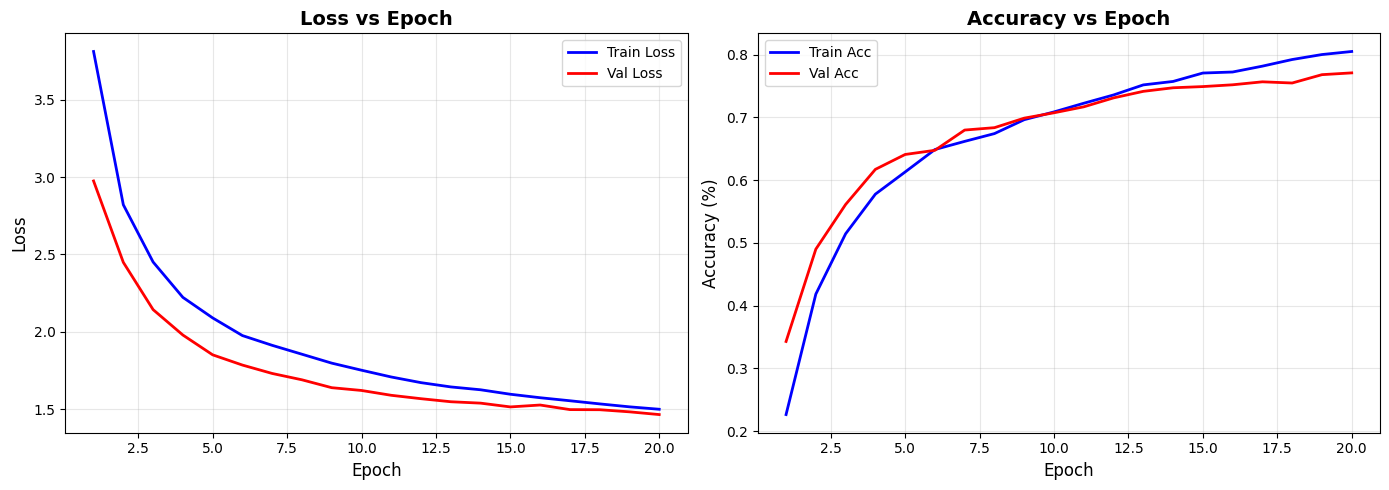

In [19]:
def plot_graph(train_losses, val_losses, train_accs, val_accs, num_epochs=20):
    epochs_range = range(1, num_epochs + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Loss plot
    ax1.plot(epochs_range, train_losses, 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs_range, val_losses, 'r-', label='Val Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Loss vs Epoch', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Accuracy plot
    ax2.plot(epochs_range, train_accs, 'b-', label='Train Acc', linewidth=2)
    ax2.plot(epochs_range, val_accs, 'r-', label='Val Acc', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_title('Accuracy vs Epoch', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


plot_graph(training_loss, valid_loss, training_acc, valid_acc, num_epochs=20)

Test our model.

In [20]:
results = []
test_correct = 0
test_total = 0
test_loss, running_loss = 0.0, 0.0
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

model.load_state_dict(torch.load(best_weight_path))
model.to(device)
model.eval()
with torch.no_grad():
    for idx, batch in enumerate(tqdm(test_loader, desc="Testing")):
        images = batch["image"].to(device)
        questions = batch["question"].to(device)
        answers = batch["answer"].to(device)

        outputs = model(images, questions)
        loss = criterion(outputs, answers)

        running_loss += loss.item()

        probs = torch.softmax(outputs, dim=1)
        _, predicted = probs.max(dim=1)

        # Accuracy
        test_correct += (predicted == answers).sum().item()
        test_total += answers.size(0)

        # Store results (per sample)
        for i in range(answers.size(0)):
            true_idx = answers[i].item()
            pred_idx = predicted[i].item()
            dataset_idx = idx * test_loader.batch_size + i

            results.append({
                "qid": batch["qid"].item(),
                'img_name': test_dataset.data.iloc[dataset_idx]["img_name"],
                "question": tokenizer.decode(questions[i], skip_special_tokens=True),
                "true_answer": test_dataset.data.iloc[dataset_idx]["answer"],
                "predicted_answer": idx_to_ans[pred_idx],
                "confidence": probs[i, pred_idx].item(),
                "correct": int(true_idx == pred_idx)
            })

test_accuracy = 100.0 * test_correct / test_total
test_loss = running_loss / len(test_loader)

print(f"\nTest Accuracy: {test_accuracy:.2f}% ({test_correct}/{test_total})")
print(f"Test Loss: {test_loss}")

Testing: 100%|██████████| 1061/1061 [01:12<00:00, 14.59it/s]


Test Accuracy: 76.53% (812/1061)
Test Loss: 1.5231359543719458


Analyze the performance (Open and Close-ended)

In [21]:
result_df = pd.DataFrame(results)
result_df = result_df[['qid', 'true_answer', 'predicted_answer', 'correct']]
merged_df = test_df.merge(result_df, on="qid", how="left")
merged_df = merged_df[["qid", "img_name", "question", "answer_type", "answer", "predicted_answer", "correct"]]
merged_df.head(5)

,qid,img_name,question,answer_type,answer,predicted_answer,correct
0,11934,xmlab102/source.jpg,What modality is used to take this image?,OPEN,CT,CT,1
1,11935,xmlab102/source.jpg,Which part of the body does this image belong to?,OPEN,Chest,Chest,1
2,11936,xmlab102/source.jpg,What is the main organ in the image?,OPEN,"Lung, Spinal Cord",Lung,0
3,11937,xmlab102/source.jpg,What is the largest organ in the picture?,OPEN,Lung,Lung,1
4,11938,xmlab102/source.jpg,Does the picture contain liver?,CLOSED,No,No,1


In [22]:
accuracy_by_type = (
    merged_df
    .groupby("answer_type")
    .agg(total=("correct", "count"), correct=("correct", "sum"))
)

accuracy_by_type["accuracy"] = accuracy_by_type["correct"] / accuracy_by_type["total"]
accuracy_by_type

,total,correct,accuracy
answer_type,,,
CLOSED,416,334,0.802885
OPEN,645,478,0.741085


Visualize the test results.

In [25]:
import random, math

def visualize_samples(
    results, img_dir, num_samples=6, shuffle=True, figsize=(25, 5)
):
    if shuffle:
        samples = random.sample(results, min(num_samples, len(results)))
    else:
        samples = results[:num_samples]

    n_rows = 1
    n_cols = math.ceil(len(samples) / n_rows)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()

    for ax, sample in zip(axes, samples):
        image_path = os.path.join(img_dir, sample["img_name"])
        img = Image.open(image_path).convert("RGB")
        ax.imshow(img)
        ax.axis("off")

        question = textwrap.fill(f"Q: {sample['question']}", width=40)
        gt = textwrap.fill(f"GT: {sample['true_answer']}", width=40)
        pred = textwrap.fill(f"Pred: {sample['predicted_answer']}", width=40)
        status = "✅ Correct" if sample["correct"] else "❌ Wrong"

        title = f"{question}\n{gt}\n{pred}\n{status}"
        ax.set_title(title, fontsize=11, loc="center")

    for ax in axes[len(samples):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

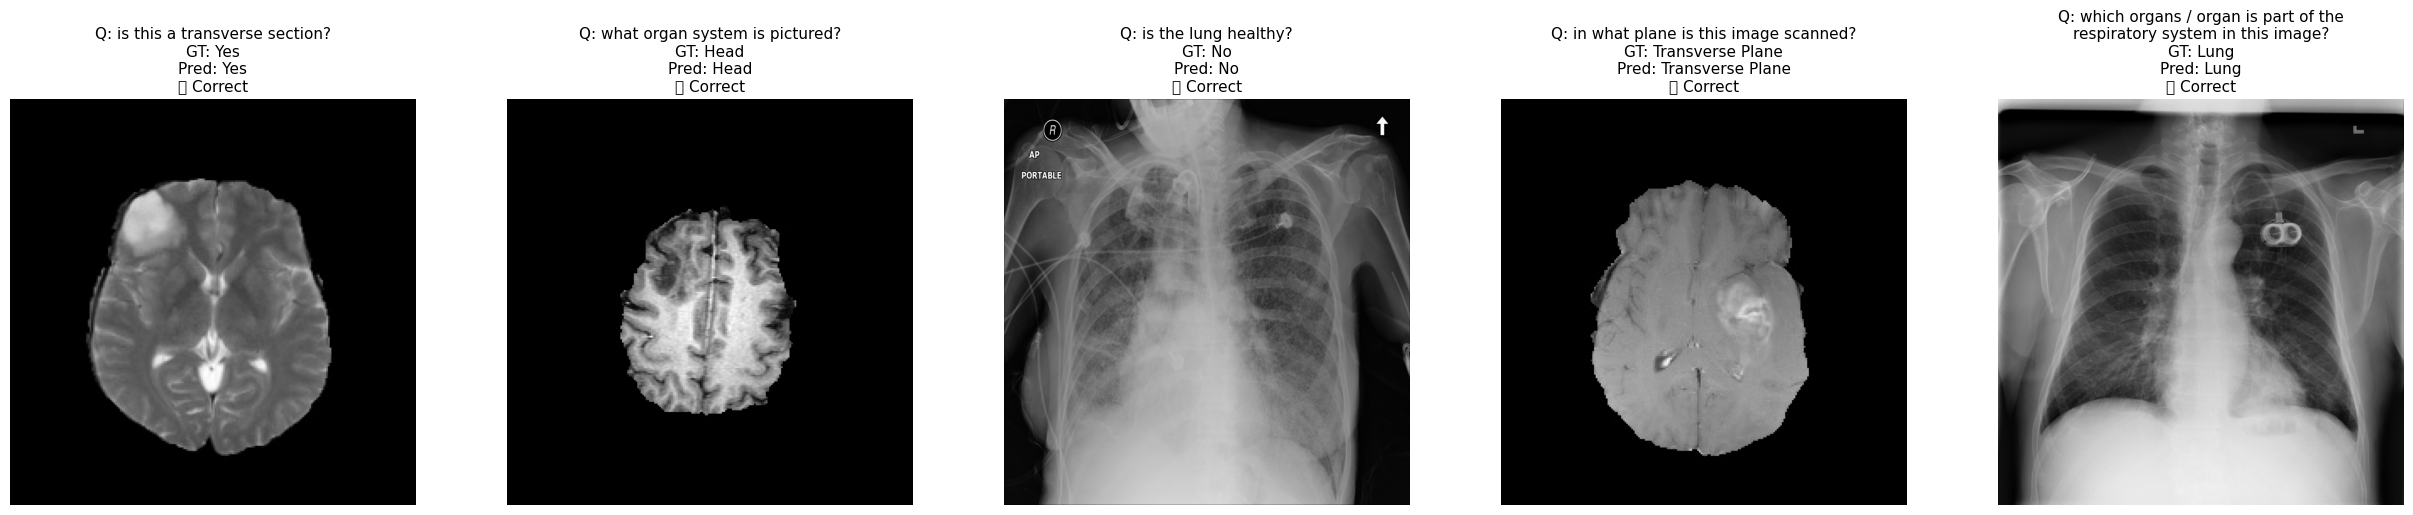

In [26]:
visualize_samples(results, img_dir, num_samples=5)